# Total heatwave exposures

From the health system perspective, we'd like to know not just exposures to change (which in the climate perspective is useful to demonstrate that  HWs are really forming a trend relative to the null hypothesis of being normally distributed around 0) - but the absolute values with the idea to know a) how big is this change from 'normal' and b) how it compares to what we already cope with. More generally the idea is that if you measure millions more exposure days but on a total value of billions, then even if you pick out a statistucally significant trend you might not (from the policy POV) care that much. On the other hand if you are talking 2x historical it's an issue.

The ideal is to show 'percentage change' rel. to a baseline. the problem is the population data doesn't exist and even if it does, it doesn't make sense to average over 20years like we do for climatologies.

The first step is to just calculate absolute valeus - these aren't too problematic since anyway the 'HW delta' is kinda double-normalising since we 1x used 20y period for climatology then again for the baseline of the delta. Just plotting then the time series gives a pretty good idea of where you stand relative to'normal'

The next idea is to copy how GDP is presented as a percentage year-to-year. Since it doesn't make sense with pop to normalise to a baseline period, and it's very arbitrary to pick one year of period, instead plot the percentage change from previous year (e.g. https://fred.stlouisfed.org/graph/?g=eUmi)


In [33]:
from pathlib import Path
import numpy as np
import pandas as pd

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cartopy import crs as ccrs
from scipy import stats

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

In [2]:
# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [3]:
MAP_PROJECTION = ccrs.EckertIII()

In [4]:
MAX_YEAR = 2021

REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('../results/heatwaves/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2022'

GPW_FILE = DATA_SRC/ 'lancet/population/UN WPP-Adjusted Population Count v4.11 2000-2020 15min era compat.nc'
# POPULATION_VAR = 'UN WPP-Adjusted Population Count, v4.11 (2000-2020)'

# DEMOGRAPHICS_TOTALS_FILE = POP_DATA_SRC / 'demographics_2000_2020_15_min_era_compat.nc'
DEMOGRAPHICS_TOTALS_FILE = POP_DATA_SRC / 'demographics_hybrid_1950_2020_15_min_era_compat.nc'

In [5]:
INFANTS_TOTALS_FILE = POP_DATA_SRC / 'infants_1950_2020_hybrid_15_min_era_compat.nc'

In [6]:
MIN_YEAR = 1980

In [13]:
# population_data = xr.open_dataset('demographics_hybrid_1950_2020_15_min.nc')
# population_total = population_data.sum(dim='age_band_lower_bound')

In [ ]:
population_total = population_data.sum(dim='age_band_lower_bound')



# Load Data

## Load GPW data

In [14]:
gpw_dat = xr.open_dataset(GPW_FILE)

## Load country data

In [15]:
COUNTRIES_RASTER = gpw_dat['National Identifier Grid, v4.11 (2010): National Identifier Grid'].load()

In [16]:
land_mask  = (COUNTRIES_RASTER < 2000)

## Load population and demographic data

In [17]:
# population = gpw_dat[POPULATION_VAR]

In [18]:
demographics_totals = xr.open_dataarray(DEMOGRAPHICS_TOTALS_FILE)
# population_over_65 = demographics_totals.sel(age_band_lower_bound=65).load()

In [19]:
population_infants = xr.open_dataarray(INFANTS_TOTALS_FILE)

## Extrapolate demographic data to 2021

In [20]:
population_over_65 = (
    xr.concat([demographics_totals, 
               demographics_totals.interp(year=2021, kwargs=dict(fill_value="extrapolate")).compute()
              ], 'year').sel(age_band_lower_bound=65).load())

In [21]:
population_infants = (
    xr.concat([population_infants, 
               population_infants.interp(year=2021, kwargs=dict(fill_value="extrapolate")).compute()
              ], 'year').load())

## Load heatwave lengths and counts data

> TODO would like to split this up into yearly files so I only need to re-do one year at a time...

In [22]:
heatwave_metrics_files = sorted((INTERMEDIATE_RESULTS_FOLDER / 'heatwave_days_era5').glob('*.nc'))
heatwave_metrics = xr.open_mfdataset(heatwave_metrics_files, combine='by_coords')

###  SKIPPED ~~Calculate the difference from the mean number of days and number of events~~

In [10]:
# heatwaves_metrics_reference = heatwave_metrics.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
# heatwave_metrics_delta = heatwave_metrics - heatwaves_metrics_reference


## Calculate some utility data

In [23]:
# Get the grid weighting factor from the latitude
cos_lat = np.cos(np.radians(heatwave_metrics.latitude))
# Get the total population for normalising
total_pop_over_65 = population_over_65.sum(dim=['latitude', 'longitude'], skipna=True)

# Calculate total exposures and save for all metrics

Because the calculation is the same for all metrics, we can calculated it once on the dataset and save

In [24]:
exposures_over65 = heatwave_metrics * population_over_65

In [25]:
# exposures_over65.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_over65_multi_threshold_{MIN_YEAR}-{MAX_YEAR}.nc')

In [26]:
exposures_infants = heatwave_metrics * population_infants

In [27]:
# exposures_infants.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_infants_multi_threshold_{MIN_YEAR}-{MAX_YEAR}.nc')

In [28]:
# exposures = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_multi_threshold_2000-{MAX_YEAR}.nc')

## Total Exposure to change in  to heatwaves

Calculate exposure changes in terms of difference aspects of heatwaves - frequency, length, load. 

> **NOTE**: Keep the of number of individual events (rather than number of days) for historical reasons, but no longer focus on that because number of heatwave days is just generally a better measure than individual instances.


In [29]:
total_exposures_over65 = exposures_over65.sum(dim=['latitude', 'longitude']).to_dataframe()
total_exposures_infants = exposures_infants.sum(dim=['latitude', 'longitude']).to_dataframe()

In [30]:
# total_exposures_infants.to_excel(RESULTS_FOLDER / 'heatwave_exposure_indicator_totals_infants.xlsx')
# total_exposures_infants.to_csv(RESULTS_FOLDER / 'heatwave_exposure_indicator_totals_infants.csv')

# Weighted mean change

In [31]:
weighted_mean_infants = (exposures_infants / population_infants.sum(dim=['latitude', 'longitude']))

In [34]:
divnorm = colors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=400)

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


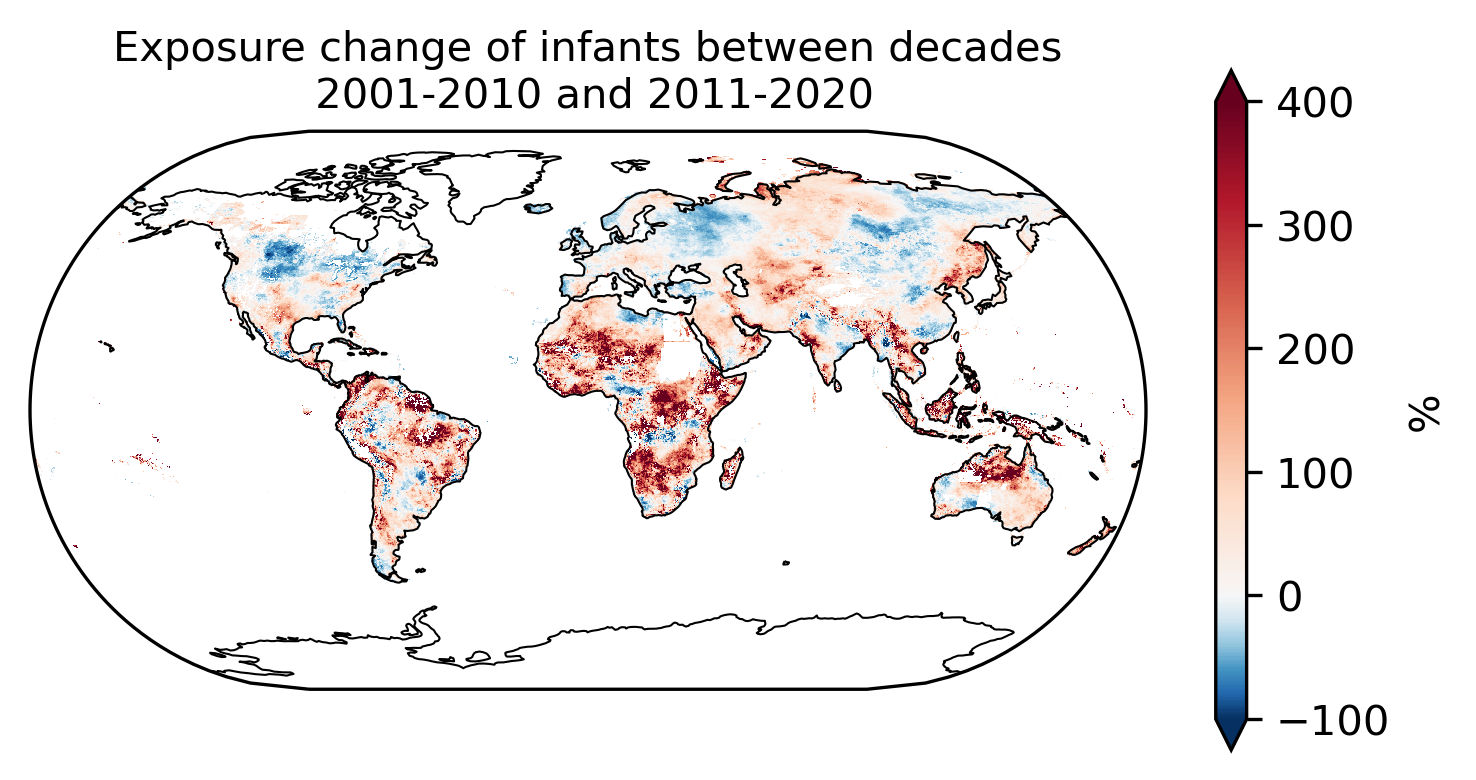

In [38]:
baseline = weighted_mean_infants.sel(year=slice(2001,2010)).mean(dim='year')
decadal = 100 * (weighted_mean_infants.sel(year=slice(2011,2020)).mean(dim='year') - baseline) / baseline
decadal = decadal.compute()

f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION),dpi=300)

decadal.heatwaves_days.plot.pcolormesh(
    norm=divnorm,
#     robust=True,
#                             vmin=-100, vmax=400, cmap='plasma',
                            cbar_kwargs=dict(label='%'),
                            transform=ccrs.PlateCarree(),
                            ax=ax)

ax.coastlines(linewidth=0.5)
ax.set_title(f'Exposure change of infants between decades\n 2001-2010 and 2011-2020')
f.savefig(RESULTS_FOLDER / 'decade change lt 1.png')
f.savefig(RESULTS_FOLDER / 'decade change lt 1.pdf')

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


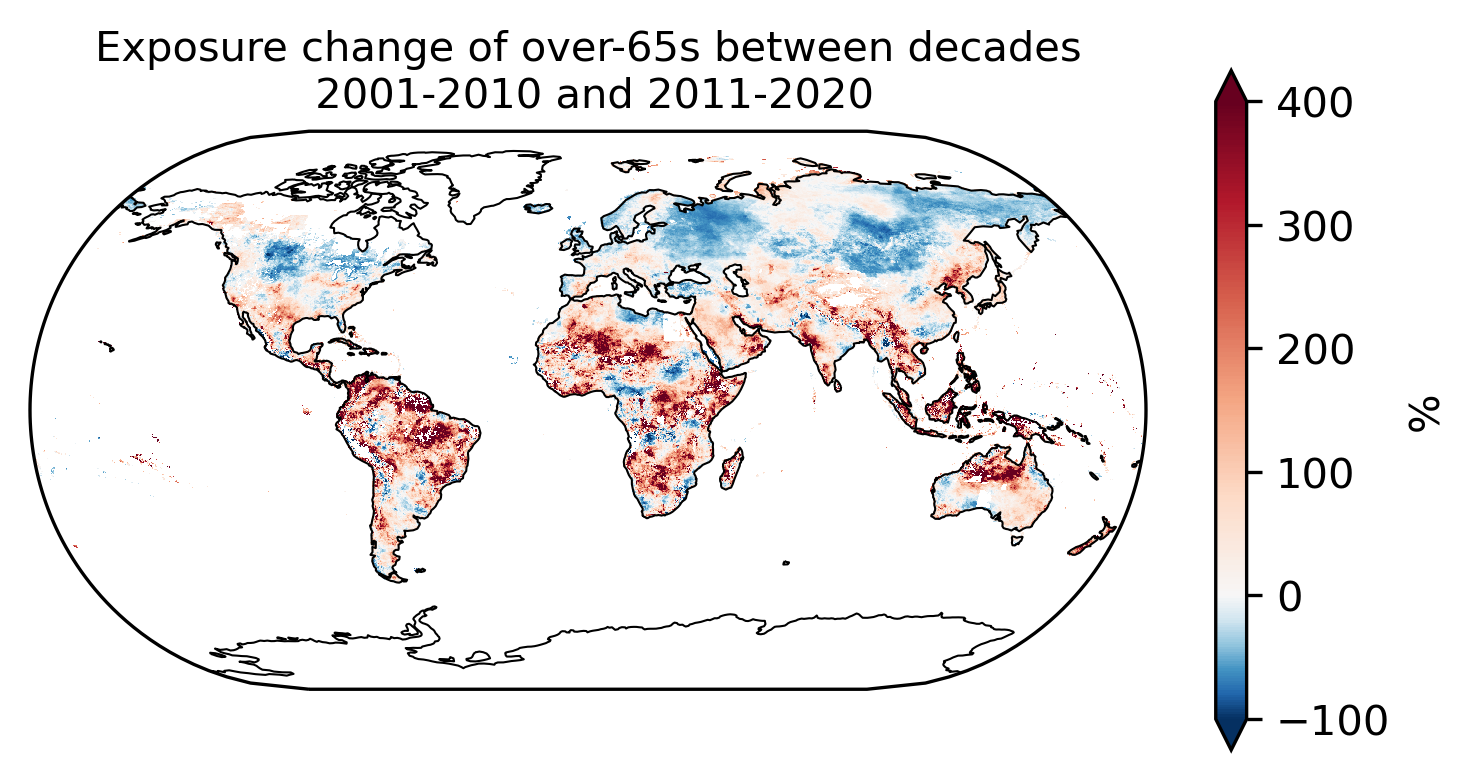

In [37]:
weighted_mean_over65 = (exposures_over65 / population_over_65.sum(dim=['latitude', 'longitude']))

baseline = weighted_mean_over65.sel(year=slice(2001,2010)).mean(dim='year')
decadal = 100 * (weighted_mean_over65.sel(year=slice(2011,2020)).mean(dim='year') - baseline) / baseline
decadal = decadal.compute()

f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION),dpi=300)

decadal.heatwaves_days.plot(norm=divnorm,
#                             robust=True,
#                             vmin=-100, vmax=400, cmap='plasma',
                            cbar_kwargs=dict(label='%'),
                            transform=ccrs.PlateCarree(),
                            ax=ax)

ax.coastlines(linewidth=0.5)
ax.set_title(f'Exposure change of over-65s between decades\n 2001-2010 and 2011-2020')
f.savefig(RESULTS_FOLDER / 'decade change over 65.png')
f.savefig(RESULTS_FOLDER / 'decade change over 65.pdf')

In [50]:
# weighted_mean_infants = ((exposures_infants / population_infants.sum(dim=['latitude', 'longitude']))
#                           .sum(dim=['latitude', 'longitude'],
#                                skipna=True).to_dataframe())

In [23]:
# weighted_mean_infants.to_excel(RESULTS_FOLDER / 'heatwave_metrics_weighted_infants.xlsx')

# Plots


In [164]:
exposures = pd.concat([total_exposures_over65.heatwaves_days, total_exposures_infants.heatwaves_days], axis=1)
exposures.columns = ['Over 65', 'Infants']

[Text(0, 0.5, 'Total exposure [Person-days]')]

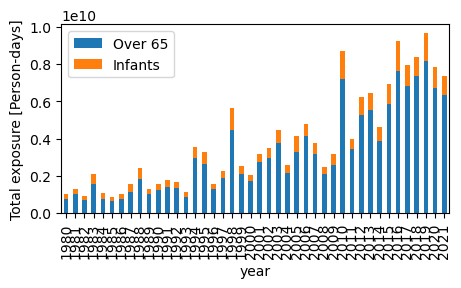

In [165]:
ax = exposures.plot.bar(stacked=True)
ax.set(
    ylabel='Total exposure [Person-days]'
)

## Year on year change

> Comms problem: this is correct but doesn't necessarily read how you'd like => in line with the GDP plos, a consistent growth translates as flattish line about zero - this tells you that you have consistently growth each year but doesn't give that impression to non-expert. Worse, because the absolute values have increased a lot, the year-on-year percentages actually shrunk! because the denominator is so large - so makes it look like its 'calmed down' in 2015-2000 when instead it's hovered around a very high value. We can address a bit with the cumulative plot, but like the others is also gives a false impression 'levelling off' because the values are so big, the percentage changes on those values 'look' smalled...

In [38]:
pct_change = pd.DataFrame( (exposures.values[1:] - exposures.values[:-1])/exposures.values[:-1],
                         index=exposures.index[1:], columns=exposures.columns
                         )

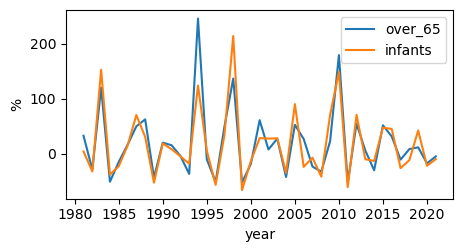

In [99]:
ax = (pct_change * 100).plot()
ax.set(ylabel='%');

## Relative to full baseline (but change in exposures instead of exposure to change, so with 'bad' pop data)

[Text(0, 0.5, '% change'),
 Text(0.5, 1.0, 'Change in total exposures relative to 1986-2005 average')]

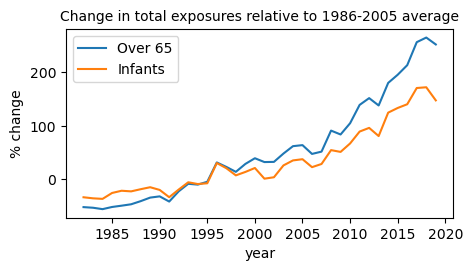

In [187]:
baseline = exposures.loc[1985:2005].mean()
rel_base = 100 * (exposures - baseline) / baseline

ax = rel_base.rolling(5, center=True).mean().plot()
ax.set(
    ylabel='% change',
    title='Change in total exposures relative to 1986-2005 average'
)

## Relative to short arbitrary base line

Ok fine i don't like it but we can just try a comparison using 'start 2000s' as baseline, with the idea to say things were still kinda 'ok' in 2000. 

[Text(0, 0.5, 'Billion person-days'), Text(0.5, 1.0, 'Total exposures')]

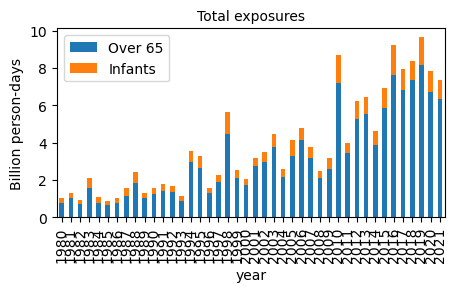

In [183]:
ax = (exposures/1e9).plot.bar(stacked=True)
ax.set(
    ylabel='Billion person-days',
    title='Total exposures to heatwaves'
)
# ax.axhline(exposures.loc[1986:2005].mean().sum())

<AxesSubplot:xlabel='year'>

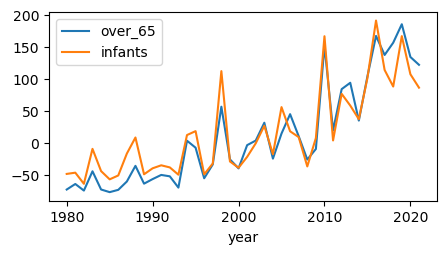

In [126]:
baseline = exposures.loc[2000:2009].mean()
rel_2k = 100 * (exposures - baseline) / baseline

rel_2k.plot()

In [ ]:
baseline = exposures.loc[2000:2009].mean()
rel_2k = 100 * (exposures - baseline) / baseline

rel_2k.plot()